In [1]:
%matplotlib inline
import pylab
import seaborn
import numpy as np
import nengo

In [2]:
class RegularSpiking(object):
    def __init__(self, size, dt=0.001):
        self.state = np.zeros(size)
        self.threshold = 1.0 / dt
        self.output = np.zeros(size)
    def __call__(self, t, x):
        self.output[:] = 0
        self.state += x
        spikes = np.where(self.state > self.threshold)
        self.output[spikes] = self.threshold
        self.state -= self.output
        return self.output

Here, we just check if there are any events within dt time, and if there are, we assume there is only one of them.

This is a horrible approximation.  Don't do this.

In [3]:
class PoissonSpikingApproximate(object):
    def __init__(self, size, seed, dt=0.001):
        self.rng = np.random.RandomState(seed=seed)
        self.dt = dt
        self.value = 1.0 / dt
        self.size = size
        self.output = np.zeros(size)
    def __call__(self, t, x):
        self.output[:] = 0
        p = 1.0 - np.exp(-x*self.dt)
        self.output[p>self.rng.rand(self.size)] = self.value
        return self.output

For this attempt, I'm screwing something up in the logic, as it's firing more frequently than it should.  The idea is to use the same approach as above to see if *any* spikes happen during the dt.  If there are any spikes, then count that as 1 spike.  But now I need to know if there are any more spikes (given that we know at least one spike happened).  Since one spike happened at one instant in time, but all the other points in time during that dt could also have a spike (since the whole point of a poisson process is that everything's independent), we can remove that one infinitessimal point in take from dt, leaving us with dt, and we can check if any spikes happened in that remaining time.  In other words, just do the same process over again, only considering those neurons who did spike on the previous iteration of this logic.  Continue until no neurons have another spike.

I'm not sure if my logic is bad or my coding is bad, but this doesn't work.

In [4]:
class PoissonSpikingExactBad(object):
    def __init__(self, size, seed, dt=0.001):
        self.rng = np.random.RandomState(seed=seed)
        self.dt = dt
        self.value = 1.0 / dt
        self.size = size
        self.output = np.zeros(size)
    def __call__(self, t, x):
        p = 1.0 - np.exp(-x*self.dt)
        self.output[:] = 0
        s = np.where(p>self.rng.rand(self.size))[0]
        self.output[s] += self.value
        count = len(s)
        while count > 0:
            s2 = np.where(p[s]>self.rng.rand(count))[0]
            s = s[s2]
            self.output[s] += self.value
            count = len(s)
            
        return self.output

Now for one that works.  Here we do the approach of actually figuring out when during the time step the events happen, and continue until we fall off the end of the timestep.  This is how everyone says to do it.

In [5]:
class PoissonSpikingExact(object):
    def __init__(self, size, seed, dt=0.001, parrot=False):
        self.rng = np.random.RandomState(seed=seed)
        self.dt = dt
        self.value = 1.0 / dt
        self.size = size
        self.parrot = parrot
        if parrot:
            size=1
        self.output = np.zeros(size)
    def next_spike_times(self, rate):        
        rate = [rate[0]] if self.parrot else rate
        return -np.log(1.0-self.rng.rand(len(rate))) / rate
    def __call__(self, t, x):
        self.output[:] = 0
                
        next_spikes = self.next_spike_times(x)
        s = np.where(next_spikes<self.dt)[0]
        count = len(s)
        self.output[s] += self.value
        while count > 0:
            next_spikes[s] += self.next_spike_times(x[s])
            s2 = np.where(next_spikes[s]<self.dt)[0]
            count = len(s2)
            s = s[s2]
            self.output[s] += self.value
                
        return np.ones((self.size))*self.output

In [6]:
model = nengo.Network()
with model:
    freq=10
    stim = nengo.Node(lambda t: np.sin(t*np.pi*2*freq))
    ens = nengo.Ensemble(n_neurons=5, dimensions=1, neuron_type=nengo.LIFRate(), seed=1)
    nengo.Connection(stim, ens, synapse=None)
    
    regular_spikes = nengo.Node(RegularSpiking(ens.n_neurons), size_in=ens.n_neurons)
    nengo.Connection(ens.neurons, regular_spikes, synapse=None)

    poisson_spikes = nengo.Node(PoissonSpikingExact(ens.n_neurons, seed=1), size_in=ens.n_neurons)
    nengo.Connection(ens.neurons, poisson_spikes, synapse=None)
    
    p_rate = nengo.Probe(ens.neurons)
    p_regular = nengo.Probe(regular_spikes)
    p_poisson = nengo.Probe(poisson_spikes)
sim = nengo.Simulator(model)
sim.run(0.1)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

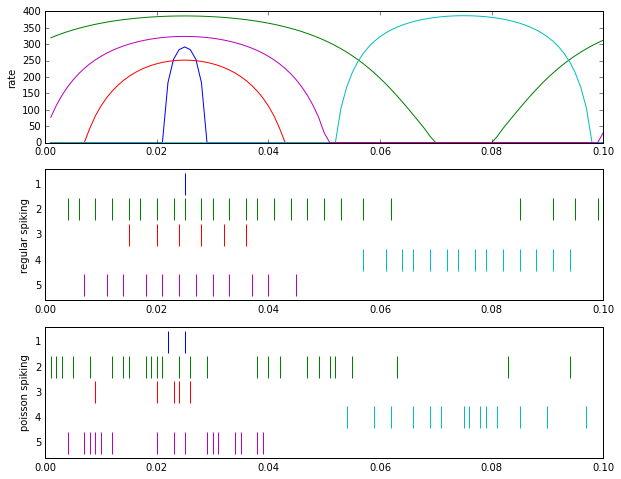

In [7]:
pylab.figure(figsize=(10,8))

pylab.subplot(3,1,1)
pylab.plot(sim.trange(), sim.data[p_rate])
pylab.xlim(0, sim.time)
pylab.ylabel('rate')

pylab.subplot(3,1,2)
import nengo.utils.matplotlib
nengo.utils.matplotlib.rasterplot(sim.trange(), sim.data[p_regular])
pylab.xlim(0, sim.time)
pylab.ylabel('regular spiking')

pylab.subplot(3,1,3)
nengo.utils.matplotlib.rasterplot(sim.trange(), sim.data[p_poisson])
pylab.xlim(0, sim.time)
pylab.ylabel('poisson spiking')



pylab.show()

Let's test the accuracy of these models.

In [8]:
def test_accuracy(cls, rate, T=1):
    test_model = nengo.Network()
    with test_model:
        stim = nengo.Node(rate)
        spikes = nengo.Node(cls(1, seed=1), size_in=1)
        nengo.Connection(stim, spikes, synapse=None)

        p = nengo.Probe(spikes)
    sim = nengo.Simulator(test_model)
    sim.run(T, progress_bar=False)
    return np.mean(sim.data[p])

In [9]:
rates = np.linspace(0, 1000, 11)
result_approx = [test_accuracy(PoissonSpikingApproximate, r) for r in rates]
result_bad = [test_accuracy(PoissonSpikingExactBad, r) for r in rates]
result_exact = [test_accuracy(PoissonSpikingExact, r) for r in rates]

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

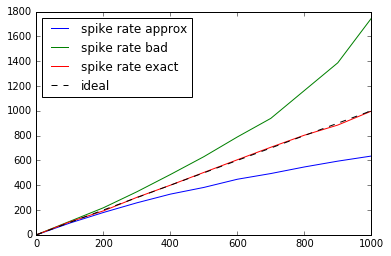

In [10]:
pylab.plot(rates, result_approx, label='spike rate approx')
pylab.plot(rates, result_bad, label='spike rate bad')
pylab.plot(rates, result_exact, label='spike rate exact')
pylab.plot(rates, rates, ls='--', c='k', label='ideal')
pylab.legend(loc='best')
pylab.show()

In [129]:
from nengo.params import Parameter, NumberParam, FrozenObject

class PoissonGenerator(object):
    def __init__(self, rate, size, seed, dt=0.001, parrot=True):
        self.rng = np.random.RandomState(seed=seed)
        self.dt = dt
        self.value = 1.0 / dt
        self.size = size
        self.parrot = parrot
        self.rate = float(rate)
        self.output = np.zeros((1 if parrot else size))
        
    def next_spike_times(self, size):        
        return -np.log(1.0-self.rng.rand(size)) / self.rate
    
    def __call__(self, t, x):
        self.output[:] = 0
                
        next_spikes = self.next_spike_times(1 if self.parrot else self.size)
        s = np.where(next_spikes<self.dt)[0]
        count = len(s)
        self.output[s] += self.value
        while count > 0:
            next_spikes[s] += self.next_spike_times(count)
            s2 = np.where(next_spikes[s]<self.dt)[0]
            count = len(s2)
            s = s[s2]
            self.output[s] += self.value
            
        return np.array([self.output[0]]*self.size) if self.parrot else self.output
    
class Parrot(nengo.neurons.LIFRate):
    """Spiking version of the leaky integrate-and-fire (LIF) neuron model.

    Parameters
    ----------
    tau_rc : float
        Membrane RC time constant, in seconds. Affects how quickly the membrane
        voltage decays to zero in the absence of input (larger = slower decay).
    tau_ref : float
        Absolute refractory period, in seconds. This is how long the
        membrane voltage is held at zero after a spike.
    min_voltage : float
        Minimum value for the membrane voltage. If ``-np.inf``, the voltage
        is never clipped.
    amplitude : float
        Scaling factor on the neuron output. Corresponds to the relative
        amplitude of the output spikes of the neuron.
    """

    probeable = ('spikes', 'voltage', 'refractory_time')

    min_voltage = NumberParam('min_voltage', high=0)

    def __init__(self, tau_rc=0.02, tau_ref=0.002, min_voltage=0, amplitude=1):
        super(Parrot, self).__init__(
            tau_rc=tau_rc, tau_ref=tau_ref, amplitude=amplitude)
        self.min_voltage = min_voltage

    def step_math(self, dt, J, output):
        output[:] = J

In [132]:


set_dt = 0.0001
model = nengo.Network()

seed=101

with model:
    size=10
    node_poisson = nengo.Node(PoissonGenerator(1000, size, seed=seed, parrot=False, dt=set_dt), size_in=size)
    
    ens_poisson2 = nengo.Ensemble(size, 1, encoders=np.ones((size,1)), gain=np.ones((size)), 
                                 bias=np.zeros((size)), neuron_type=Parrot())
    
    ens_poisson = nengo.Ensemble(size, 1, encoders=np.ones((size,1)), gain=np.ones((size)), 
                                 bias=np.zeros((size)), neuron_type=Parrot())
    nengo.Connection(node_poisson, ens_poisson2.neurons, synapse=None)
    nengo.Connection(ens_poisson2.neurons, ens_poisson.neurons, synapse=None)



    p_node = nengo.Probe(node_poisson)
    p_ens = nengo.Probe(ens_poisson2.neurons)
sim = nengo.Simulator(model,dt=set_dt)
sim.run(0.1)




HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

[    0. 10000. 20000. 30000.]
[    0. 10000. 20000. 30000.]


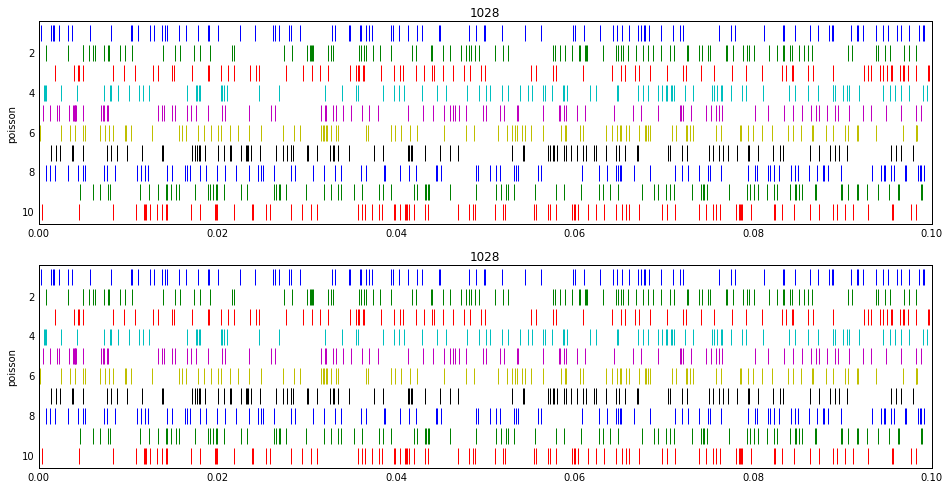

In [133]:
pylab.figure(figsize=(16,8))



pylab.subplot(2,1,1)
nengo.utils.matplotlib.rasterplot(sim.trange(), sim.data[p_node])
print(np.unique(sim.data[p_node]))
pylab.title(str(int(sim.data[p_node].mean())))
pylab.xlim(0, sim.time)
pylab.ylabel('poisson')

pylab.subplot(2,1,2)
nengo.utils.matplotlib.rasterplot(sim.trange(), sim.data[p_ens])

print(np.unique(sim.data[p_ens]))
pylab.title(str(int(sim.data[p_ens].mean())))
pylab.xlim(0, sim.time)
pylab.ylabel('poisson')


pylab.show()

In [24]:
def test_accuracy(cls, rate, T=1):
    test_model = nengo.Network()
    with test_model:
        spikes = nengo.Node(cls(rate, 5000, seed=1, parrot=True, dt=set_dt), size_in=5000)

        p = nengo.Probe(spikes)
    sim = nengo.Simulator(test_model,dt=set_dt)
    sim.run(T, progress_bar=False)
    return np.mean(sim.data[p])

In [25]:
rates = np.linspace(0, 1000, 11)
result_exact = [test_accuracy(PoissonGenerator, r) for r in rates]

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

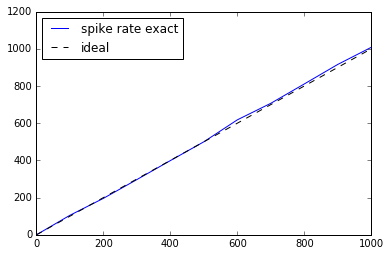

In [26]:
pylab.plot(rates, result_exact, label='spike rate exact')
pylab.plot(rates, rates, ls='--', c='k', label='ideal')
pylab.legend(loc='best')
pylab.show()

In [121]:


set_dt = 0.0001
model = nengo.Network()


with model:
    size=100
    node = nengo.Node(lambda t: [10]*size)
    ens = nengo.Ensemble(size, 1, encoders=np.ones((size,1)), gain=np.ones((size)), 
                                 bias=np.zeros((size)))
    nengo.Connection(node, ens.neurons, synapse=None)



    p_node = nengo.Probe(node)
    p_ens = nengo.Probe(ens.neurons)
sim = nengo.Simulator(model,dt=set_dt)
sim.run(.1)




HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

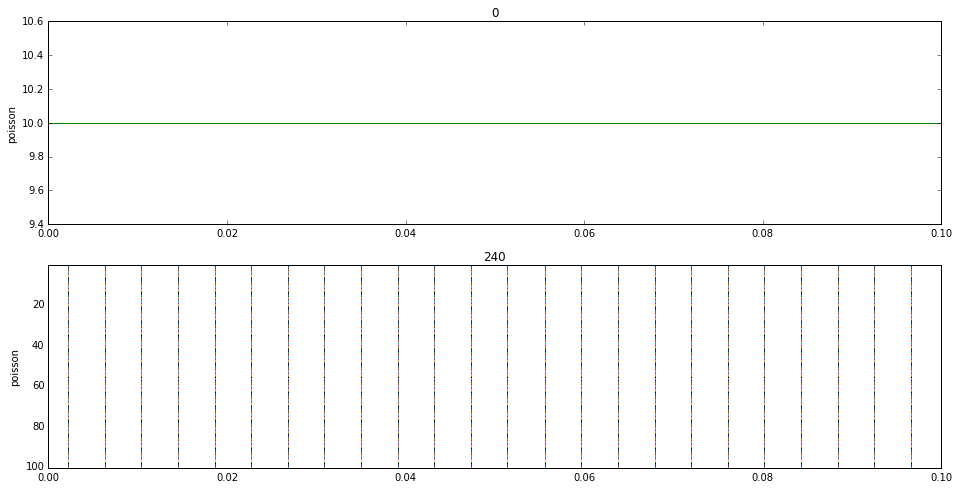

In [122]:
pylab.figure(figsize=(16,8))



pylab.subplot(2,1,1)
pylab.plot(sim.trange(), sim.data[p_node])
pylab.title(str(int(sim.data[p_node].mean()/1000)))
pylab.xlim(0, sim.time)
pylab.ylabel('poisson')

pylab.subplot(2,1,2)
nengo.utils.matplotlib.rasterplot(sim.trange(), sim.data[p_ens])
pylab.title(str(int(sim.data[p_ens].mean())))
pylab.xlim(0, sim.time)
pylab.ylabel('poisson')


pylab.show()